In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
T_0 = 300.
q_0 = 0.01864 # for 300 K SST.
    
def q_sat(T, p):
    Tc = T - 273.15

    # Arden-Buck equation.
    e_sat = 611.21 * np.exp(17.502 * Tc / (240.97 + Tc))
    Rd, Rv = 287.04, 461.5
    return Rd/Rv * e_sat / (p - (1. - Rd/Rv)*e_sat)

def calc_p_q_T_thl(z, q_0):    
    z_q1 = 4.0e3
    z_q2 = 7.5e3
    z_t = 15.e3
    q_t = 1.e-14

    q = q_0 * np.exp(-z  /z_q1) * np.exp(-(z  /z_q2)**2)

    # CvH hack to remove moisture jump.
    q_tb = q_0 * np.exp(-z_t/z_q1) * np.exp(-(z_t/z_q2)**2)
    q -= q_tb + q_t

    i_above_zt = np.where(z >= z_t)
    q[i_above_zt] = q_t

    gamma = 6.7e-3
    Tv_0 = (1. + 0.608*q_0)*T_0
    Tv = Tv_0 - gamma*z
    Tv_t = Tv_0 - gamma*z_t
    Tv[i_above_zt] = Tv_t
    T = Tv / (1. + 0.608*q)

    g = 9.79764
    Rd = 287.04
    cp = 1005.
    p0 = 101480.

    p = p0 * (Tv / Tv_0)**(g/(Rd*gamma))

    p_tmp = p0 * (Tv_t/Tv_0)**(g/(Rd*gamma)) \
          * np.exp( -( (g*(z-z_t)) / (Rd*Tv_t) ) )

    p[i_above_zt] = p_tmp[i_above_zt]

    p00 = 1e5
    thl = T*(p00/p)**(Rd/cp)

    rho = p / (Rd*Tv)

    return p, q, T, thl, rho

In [25]:
def calc_p_q_T_thl_new(z, q_0):    
    z_q1 = 4.0e3
    z_q2 = 7.5e3
    z_t = 15.e3
    q_t = 1.e-14

    q = q_0 * np.exp(-z  /z_q1) * np.exp(-(z  /z_q2)**2)

    # CvH hack to remove moisture jump.
    q_tb = q_0 * np.exp(-z_t/z_q1) * np.exp(-(z_t/z_q2)**2)
    q -= q_tb + q_t

    i_above_zt = np.where(z >= z_t)
    q[i_above_zt] = q_t

    gamma = 6.7e-3
    Tv_0 = (1. + 0.608*q_0)*T_0
    Tv = Tv_0 - gamma*z
    Tv_t = Tv_0 - gamma*z_t
    Tv[i_above_zt] = Tv_t
    T = Tv / (1. + 0.608*q)

    g = 9.79764
    Rd = 287.04
    cp = 1005.
    
    dlnp_dz = - g / (Rd*Tv)
    dz = z[1] - z[0]
    dlnp = dlnp_dz * dz
    # lnp = np.log(0.00806896906504212) + np.cumsum(-dlnp[::-1])[::-1]
    lnp = np.log(0.00806896906504212) + np.cumsum(-dlnp[::-1])[::-1]
    
    p = np.exp(lnp)
    
    p00 = 1e5
    thl = T*(p00/p)**(Rd/cp)
    
    rho = p / (Rd*Tv)

    return p, q, T, thl, rho

In [26]:
z = np.arange(0, 100e3, 0.1)
p0, q0, T0, thl0, rho0 = calc_p_q_T_thl(z, q_0)
p1, q1, T1, thl1, rho1 = calc_p_q_T_thl_new(z, q_0)
p2, q2, T2, thl2, rho2 = calc_p_q_T_thl_new(z, 1.01*q_0)

101478.85832611547 101654.85844747502 101382.94683018644


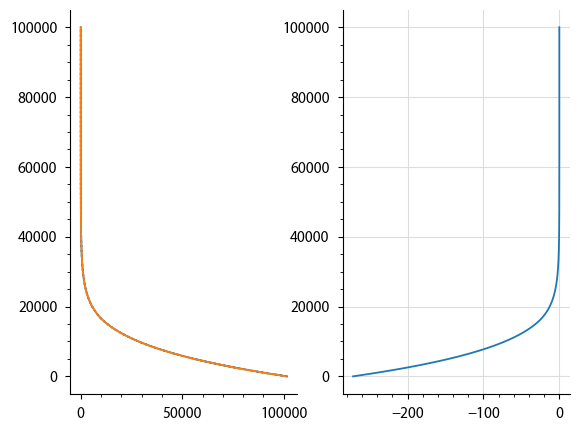

In [33]:
plt.figure()
plt.subplot(121)
plt.plot(p0, z, 'k:')
plt.plot(p1, z, 'C0-')
plt.plot(p2, z, 'C1-')
plt.subplot(122)
plt.plot(p2-p1, z)
plt.grid()
print(p0[1], p1[0], p2[0])

1e-14 1e-14


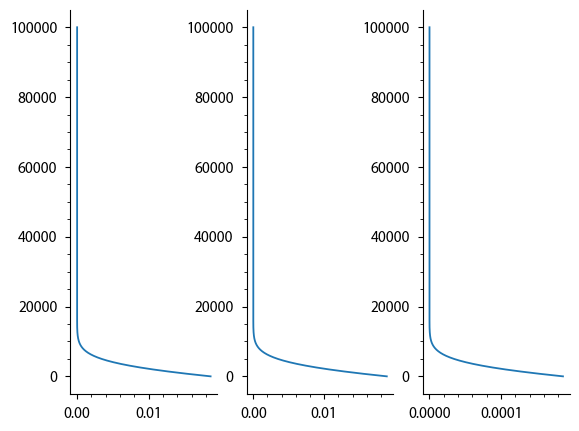

In [28]:
plt.figure()
plt.subplot(131)
plt.plot(q1, z)
plt.subplot(132)
plt.plot(q2, z)
plt.subplot(133)
plt.plot(q2-q1, z)
print(q1[-1], q2[-1])

1.3854824377783751e-07 1.3852503114540907e-07


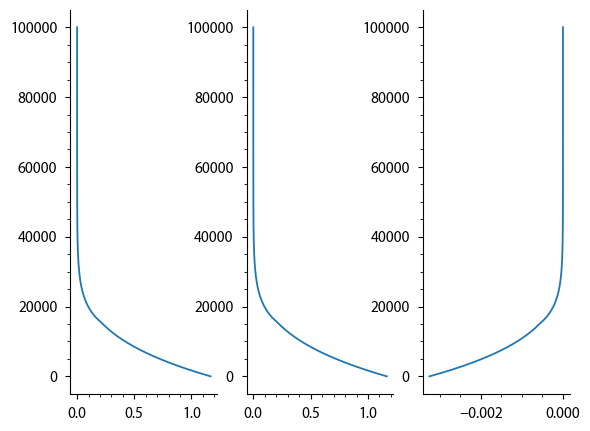

In [29]:
plt.figure()
plt.subplot(131)
plt.plot(rho1, z)
plt.subplot(132)
plt.plot(rho2, z)
plt.subplot(133)
plt.plot(rho2-rho1, z)
print(rho1[-1], rho2[-1])

In [30]:
dz = z[1] - z[0]
g = 9.81
dp_frac0 = np.cumsum((rho0*g*dz) / p0[0])
dp_frac1 = np.cumsum((rho1*g*dz) / p1[0])
dp_frac2 = np.cumsum((rho2*g*dz) / p2[0])

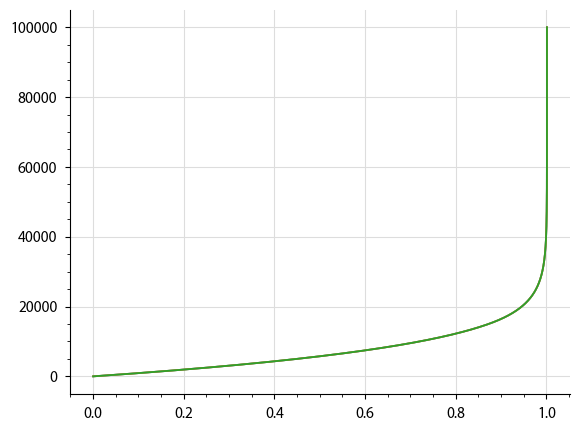

In [31]:
plt.figure()
plt.plot(dp_frac0, z)
plt.plot(dp_frac1, z)
plt.plot(dp_frac2, z)
plt.grid()